# System Characterization Experiments


In this notebook we run several system characterization experiments on the entire device:
- [T1/T2](#T1/T2)
- [Measurement fidelity](#Measurement-Fidelity)
- [Bell state fidelity](#Bell-Experiment) (as a simple proxy for two-qubit fidelity). Note this measure of Hellinger fidelity from the Bell test is sensitive to state preparation and measurement (SPAM) error as well. This particular test repeats the CX gate several times (see code, default is 5).
- [ZZ](#ZZ)

In [ ]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import rustworkx as rx
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_aer import AerSimulator

# preferred that the qiskit_device_benchmark package is installed as 'pip install .' but if not
# uncomment the following
# import sys
# sys.path.append('../')

import qiskit_device_benchmarking.utilities.graph_utils as gu

# import the qiskit experiment modules
# uses Tphi, LocalReadout, ZZ
from qiskit_experiments.library import Tphi, LocalReadoutError, ZZRamsey
from qiskit_experiments.framework import ParallelExperiment, BatchExperiment

# import the custom bell experiment
from qiskit_device_benchmarking.bench_code.bell.bell_experiment import BellExperiment

In [ ]:
# enter your account name here
acct_name = "my_account"

service = QiskitRuntimeService(name=acct_name)
backend_real = service.backend("ibm_torino")
nq = backend_real.configuration().n_qubits
coupling_map = backend_real.configuration().coupling_map

# if you want to use the simulator
# uncomment
if 0:
    backend_sim = AerSimulator.from_backend(backend_real)
    backend = backend_sim
else:
    backend = backend_real

Build batches of edges to run on that are not touching

In [225]:
# build a set of gates
G = gu.build_sys_graph(nq, coupling_map)
# get all length 2 paths in the device
paths = rx.all_pairs_all_simple_paths(G, 2, 2)
# flatten those paths into a list from the rustwork x iterator
paths = gu.paths_flatten(paths)
# remove permutations
paths = gu.remove_permutations(paths)
# convert to the coupling map of the device
paths = gu.path_to_edges(paths, coupling_map)
# make into separate sets
sep_sets = gu.get_separated_sets(G, paths, min_sep=2)

qubits_nns = gu.get_iso_qubit_list(G)

print("Number of Sets: %d" % len(sep_sets))

Number of Sets: 5


## T1/T2

In [226]:
# Time intervals to wait before measurement for t1 and t2
delays_t1 = (
    [0]
    + np.arange(1e-6, 100e-6, 10e-6).tolist()
    + np.arange(130e-6, 300e-6, 40e-6).tolist()
)
delays_t2 = (
    [0]
    + np.arange(1e-6, 100e-6, 10e-6).tolist()
    + np.arange(130e-6, 300e-6, 40e-6).tolist()
)
num_periods = 5
max_T = delays_t2[-1]
osc_freq = num_periods / (max_T)

In [227]:
# Construct the Coherence experiments

# Put Tphi experiments across the different batches
exp_batches = []
for qubits in qubits_nns:
    coh_exps = ParallelExperiment(
        [
            Tphi(
                (int(qubit),),
                delays_t1=delays_t1,
                delays_t2=delays_t2,
                t2type="hahn",
                osc_freq=osc_freq,
                backend=backend,
            )
            for qubit in np.array(qubits).flatten()
        ],
        flatten_results=False,
    )
    exp_batches.append(coh_exps)

# Batch all together
batch_exp = BatchExperiment(exp_batches, backend=backend, flatten_results=False)

In [ ]:
%%time
# Run
batch_exp.set_run_options(shots=300)
batch_exp_data = batch_exp.run()

In [232]:
batch_exp_data.status()

<ExperimentStatus.DONE: 'experiment jobs and analysis have successfully run'>

### Analyze Tphi data

Plotting Q100
['T1_Q100_7a94681e.svg', 'T2Hahn_Q100_853bf59c.svg']


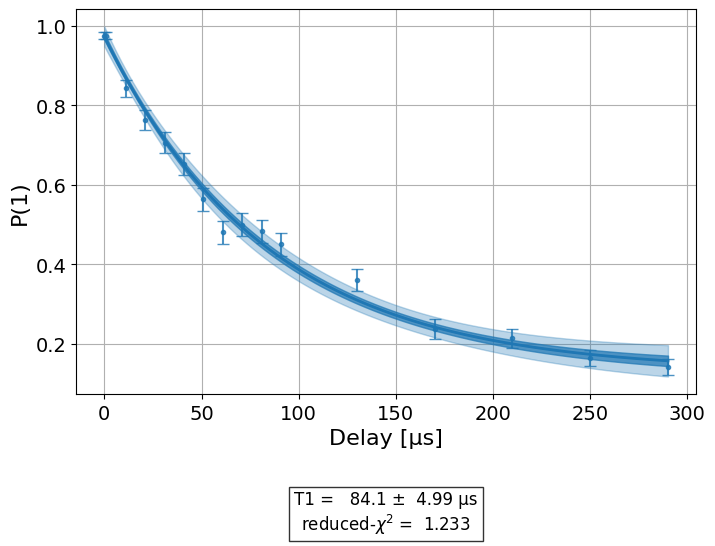

In [259]:
plot_q = 100
# 0 for the T1, 1 for the T2
plot_type = 0
plot_ind = []
found_q = False
for i in range(len(qubits_nns)):
    for j in range(len(qubits_nns[i])):
        if plot_q == qubits_nns[i][j]:
            plot_ind = [i, j]
            found_q = True
            break

    if found_q:
        break

print("Plotting Q%d" % plot_q)
print(batch_exp_data.child_data()[i].child_data()[j].figure_names)
batch_exp_data.child_data()[i].child_data()[j].figure(plot_type)

In [234]:
# generate a T1/T2 list
q_list = []
t1_list = []
t2_list = []
for i in range(len(qubits_nns)):
    data1 = batch_exp_data.child_data()[i]
    for j in range(len(qubits_nns[i])):
        # the fit didn't work for this qubit
        df = data1.child_data()[j].analysis_results(dataframe=True)
        if len(df) == 0:
            continue
        q_list.append(qubits_nns[i][j])
        t1_list.append(df[df.name == "T1"]["value"].iloc[0].nominal_value)
        t2_list.append(df[df.name == "T2"]["value"].iloc[0].nominal_value)

Text(0.5, 1.0, 'Device Coherence for ibm_torino, job d0aq9vqorbds73c3uno0')

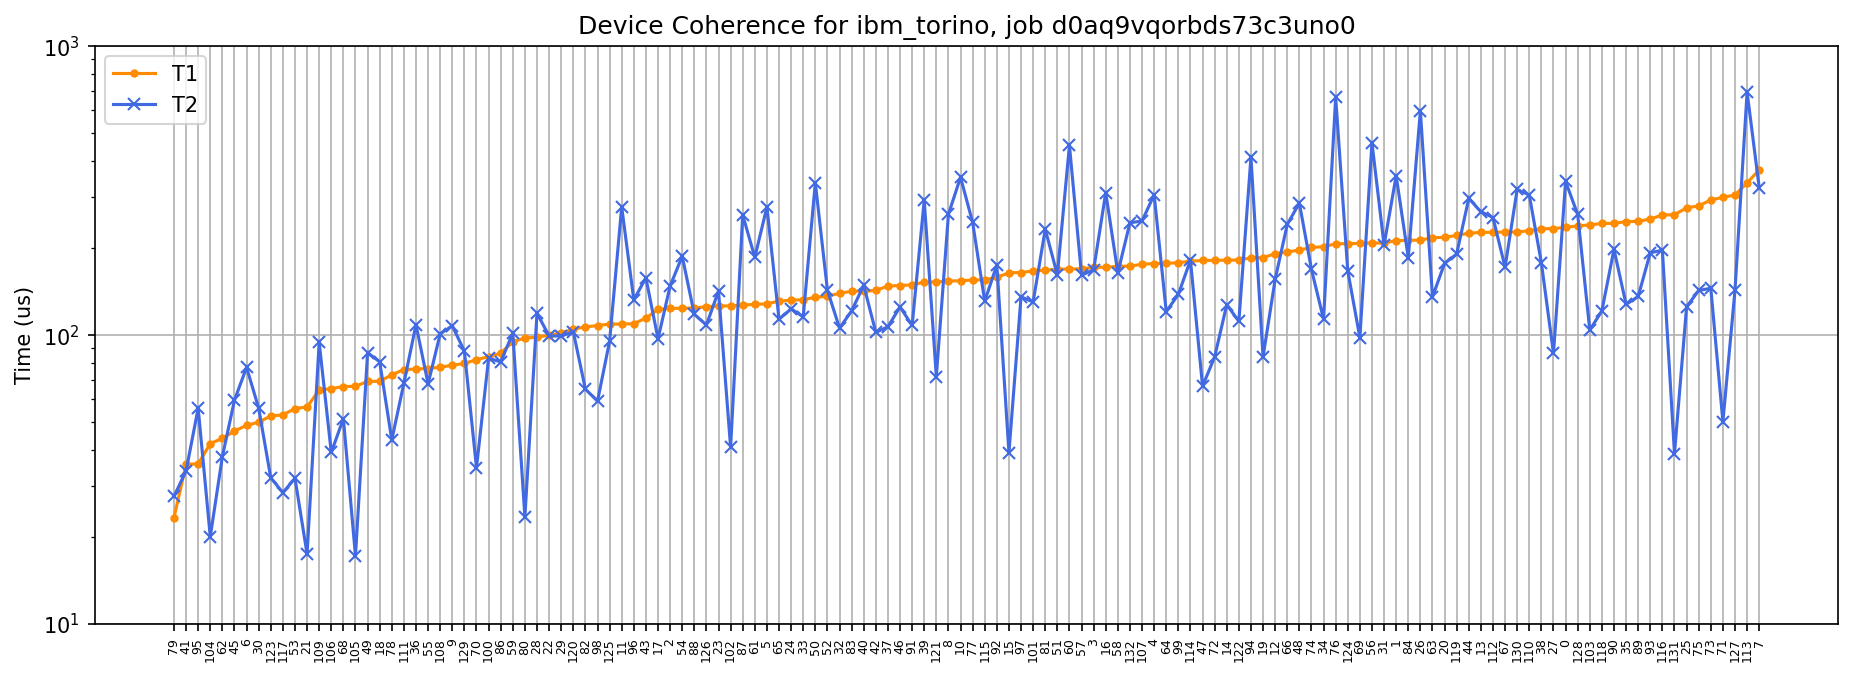

In [260]:
# plot the data ordered by T1 (need to run the cell above first)

plt.figure(dpi=150, figsize=[15, 5])
argind = np.argsort(t1_list)
plt.semilogy(
    range(len(q_list)),
    np.array(t1_list)[argind] / 1e-6,
    label="T1",
    marker=".",
    color="darkorange",
)
plt.semilogy(
    range(len(q_list)),
    np.array(t2_list)[argind] / 1e-6,
    label="T2",
    marker="x",
    color="royalblue",
)

plt.xticks(range(len(q_list)), np.array(q_list)[argind], rotation=90, fontsize=6)
plt.ylabel("Time (us)")
plt.ylim([10, 1000])
plt.grid(True)
plt.legend()
plt.title(
    "Device Coherence for %s, job %s" % (backend_real.name, batch_exp_data.job_ids[0])
)

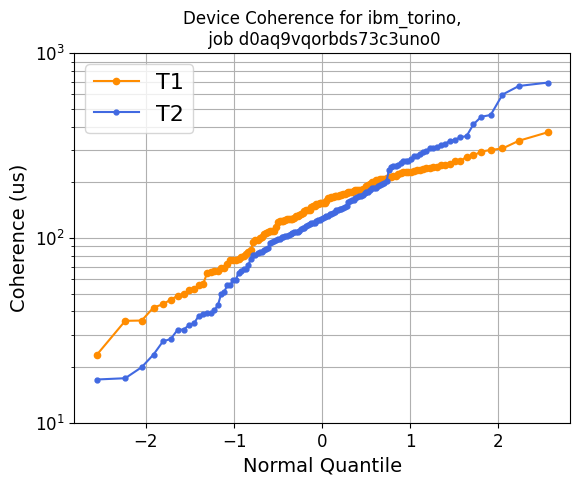

In [236]:
# Quantile plot
plt.figure(dpi=100)
x1 = stats.probplot(t1_list)
x2 = stats.probplot(t2_list)

plt.semilogy(
    x1[0][0],
    x1[0][1] / 1e-6,
    linestyle="-",
    marker=".",
    markersize=9,
    label="T1",
    color="darkorange",
)
plt.semilogy(
    x2[0][0],
    x2[0][1] / 1e-6,
    linestyle="-",
    marker=".",
    markersize=7,
    label="T2",
    color="royalblue",
)

plt.grid(True, which="both")
plt.legend(fontsize=16)
plt.xlabel("Normal Quantile", fontsize=14)
plt.ylabel("Coherence (us)", fontsize=14)
plt.ylim([10, 1000])
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title(
    "Device Coherence for %s,\n job %s" % (backend_real.name, batch_exp_data.job_ids[0])
);

## Measurement Fidelity

In [237]:
# Measurement circuits
meas_exp = LocalReadoutError(range(nq), backend=backend)

In [238]:
%%time
# Run
meas_exp.set_run_options(shots=2000)
meas_exp_data = meas_exp.run()

CPU times: user 82.2 ms, sys: 10.1 ms, total: 92.4 ms
Wall time: 1.12 s


In [239]:
meas_exp_data.status()

<ExperimentStatus.RUNNING: 'experiment jobs is actively running'>

In [240]:
# analyze, pull out the mitigator and look at the assignment fidelities
local_mit_obj = meas_exp_data.analysis_results(dataframe=True).value.iloc[0]
p0m1 = []
p1m0 = []
for i in range(nq):
    p0m1.append(local_mit_obj.assignment_matrix(i)[1, 0])
    p1m0.append(local_mit_obj.assignment_matrix(i)[0, 1])

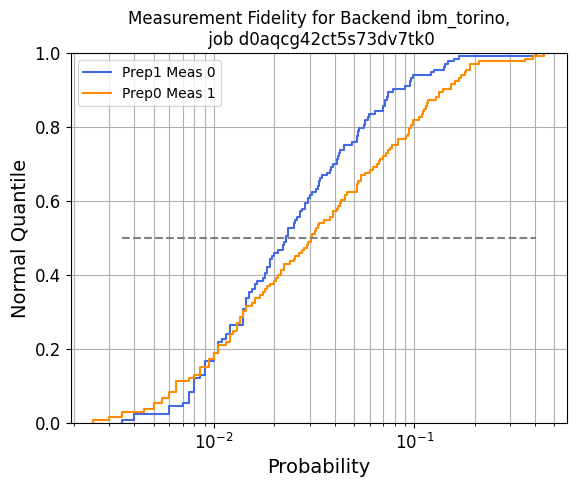

In [241]:
plt.figure(dpi=100)
plt.ecdf(p1m0, label="Prep1 Meas 0", color="royalblue")
plt.ecdf(p0m1, label="Prep0 Meas 1", color="darkorange")
plt.plot(
    np.linspace(np.min(p1m0), np.max(p1m0), 100),
    0.5 * np.ones(100),
    linestyle="--",
    color="grey",
)
plt.xscale("log")
plt.grid(True, which="both")
plt.legend()
plt.title(
    "Measurement Fidelity for Backend %s,\n job %s"
    % (backend.name, meas_exp_data.job_ids[0])
)
plt.ylabel("Normal Quantile", fontsize=14)
plt.xlabel("Probability", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12);

## Bell Experiment

In [244]:
# Bell circuits
bell_exp = BellExperiment(sep_sets, backend=backend)

In [245]:
%%time
# Run
bell_exp.set_run_options(shots=300)
bell_exp_data = bell_exp.run()

CPU times: user 197 ms, sys: 7.19 ms, total: 205 ms
Wall time: 1 s


In [249]:
bell_exp_data.status()

<ExperimentStatus.DONE: 'experiment jobs and analysis have successfully run'>

In [250]:
# Pull the data from the dataframe
df = bell_exp_data.analysis_results(dataframe=True).value.iloc[0]
bell_edge_list = []
bell_fid_list = []
for i in df.iterrows():
    bell_edge_list.append(i[1]["connection"])
    bell_fid_list.append(i[1]["fidelity"])

Text(0.5, 1.0, 'Bell Edges for ibm_torino, job d0aq9vqorbds73c3uno0')

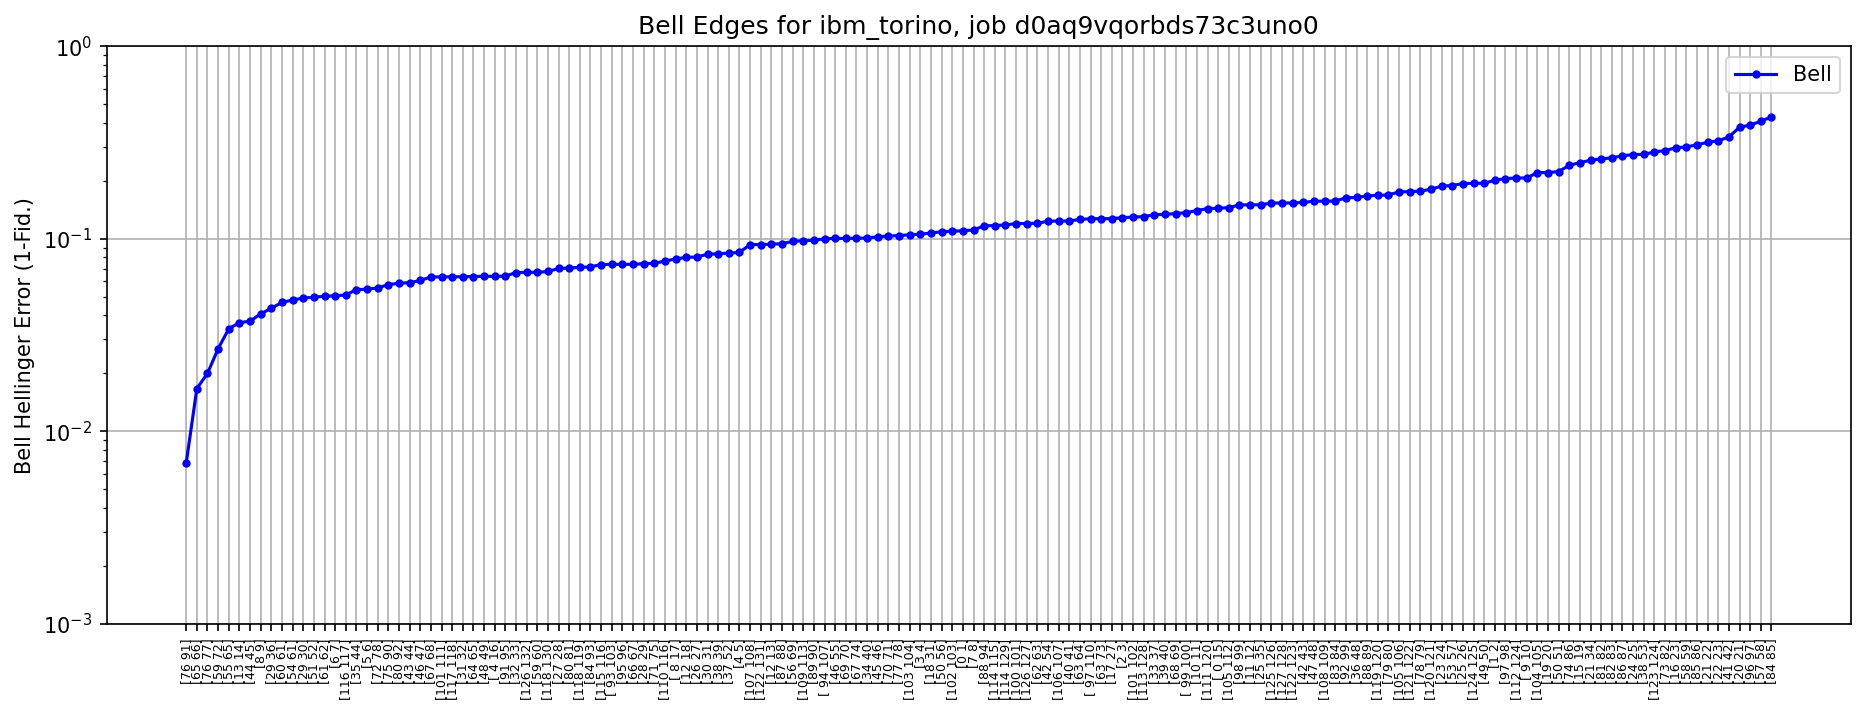

In [251]:
# plot the data ordered by Bell state fidelity (need to run the cell above first)

plt.figure(dpi=150, figsize=[15, 5])
argind = np.argsort(1 - np.array(bell_fid_list))
plt.semilogy(
    range(len(bell_edge_list)),
    1 - np.array(bell_fid_list)[argind],
    label="Bell",
    color="blue",
    marker=".",
)

plt.xticks(
    range(len(bell_edge_list)),
    np.array(bell_edge_list)[argind],
    rotation=90,
    fontsize=6,
)
plt.ylabel("Bell Hellinger Error (1-Fid.)")
plt.ylim([1e-3, 1])
plt.grid(True)
plt.legend()
plt.title("Bell Edges for %s, job %s" % (backend_real.name, batch_exp_data.job_ids[0]))

## ZZ

In [247]:
# Construct the ZZ experiments

# Put Tphi experiments across the different batches
exp_batches_zz = []
for edge_sets in sep_sets:
    zz_exps = ParallelExperiment(
        [
            ZZRamsey(
                (int(i[0]), int(i[1])),
                min_delay=1e-6,
                max_delay=10e-6,
                num_delays=41,
                num_rotations=10,
                backend=backend,
            )
            for i in edge_sets
        ],
        flatten_results=False,
    )
    exp_batches_zz.append(zz_exps)

# Batch all together
batch_exp_zz = BatchExperiment(exp_batches_zz, backend=backend, flatten_results=False)

In [ ]:
%%time
# Run
batch_exp_zz.set_run_options(shots=300)
batch_exp_zz_data = batch_exp_zz.run()

In [252]:
batch_exp_zz_data.status()

<ExperimentStatus.DONE: 'experiment jobs and analysis have successfully run'>

Plotting Edge [0, 1]
['ZZRamsey_Q0_Q1_ba433b99.svg']


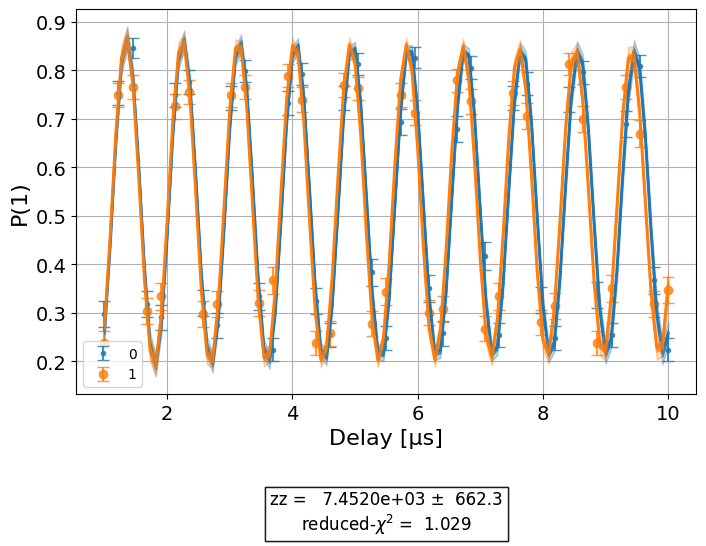

In [253]:
plot_edge = [0, 1]
# 0 for the T1, 1 for the T2
plot_ind = []
found_edge = False
for i in range(len(sep_sets)):
    for j in range(len(sep_sets[i])):
        if plot_edge == sep_sets[i][j]:
            plot_ind = [i, j]
            found_edge = True
            break

    if found_edge:
        break

if not found_edge:
    print("Did not find specified edge. Try swapping the direction.")


print("Plotting Edge %s" % plot_edge)
print(batch_exp_zz_data.child_data()[i].child_data()[j].figure_names)
batch_exp_zz_data.child_data()[i].child_data()[j].figure(0)

In [254]:
# generate a ZZ list
edge_list = []
zz_list = []
for i in range(len(sep_sets)):
    data1 = batch_exp_zz_data.child_data()[i]
    for j in range(len(sep_sets[i])):
        # the fit didn't work for this qubit
        df = data1.child_data()[j].analysis_results(dataframe=True)
        if len(df) == 0:
            continue

        # skip the bad fits
        if df.iloc[0].chisq > 10:
            print(
                "Skip edge %s, chisq too high %f" % (sep_sets[i][j], df.iloc[0].chisq)
            )
            continue
        edge_list.append(sep_sets[i][j])
        zz_list.append(np.abs(df.iloc[0].value.nominal_value))

In [216]:
zz_inds = np.argsort(zz_list)
# np.array(zz_list)[zz_inds[-1]]
# np.array(edge_list)[zz_inds[-1]]

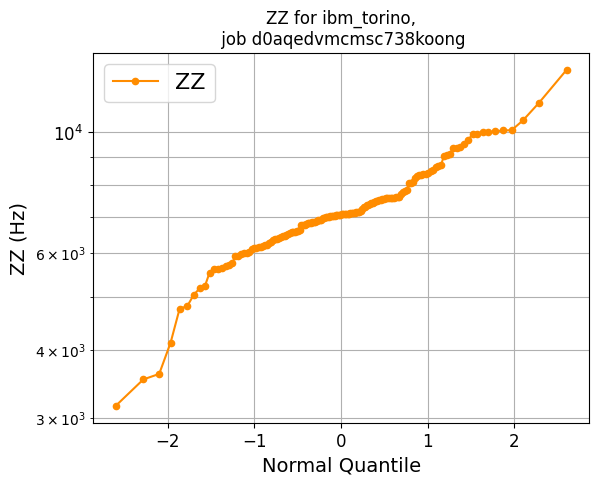

In [255]:
# Quantile plot
plt.figure(dpi=100)
x1 = stats.probplot(zz_list)

plt.semilogy(
    x1[0][0],
    x1[0][1],
    linestyle="-",
    marker=".",
    markersize=9,
    label="ZZ",
    color="darkorange",
)

plt.grid(True, which="both")
plt.legend(fontsize=16)
plt.xlabel("Normal Quantile", fontsize=14)
plt.ylabel("ZZ (Hz)", fontsize=14)
# plt.ylim([1000,100000])
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title("ZZ for %s,\n job %s" % (backend_real.name, batch_exp_zz_data.job_ids[0]));

In [177]:
from IPython.display import HTML, display
import datetime


def qiskit_copyright(line="", cell=None):
    """IBM copyright"""
    now = datetime.datetime.now()

    html = "<div style='width: 100%; background-color:#d5d9e0;"
    html += "padding-left: 10px; padding-bottom: 10px; padding-right: 10px; padding-top: 5px'>"
    html += "<p>&copy; Copyright IBM 2017, %s.</p>" % now.year
    html += (
        "<p>This code is licensed under the Apache License, Version 2.0. You may<br>"
    )
    html += "obtain a copy of this license in the LICENSE.txt file in the root directory<br> "
    html += "of this source tree or at http://www.apache.org/licenses/LICENSE-2.0."

    html += "<p>Any modifications or derivative works of this code must retain this<br>"
    html += "copyright notice, and modified files need to carry a notice indicating<br>"
    html += "that they have been altered from the originals.</p>"
    html += "</div>"
    return display(HTML(html))


qiskit_copyright()